# Texas Choroshape Examples

This script creates county-level choropleth maps for Texas demographic data. It creates some basic classes and walks through some use cases. City and county shapefiles were created with ArcGIS and have not been included. Colors were chosen using Color Brewer 2.0 (http://colorbrewer2.org/).
<br/><br/>
All data is publicly available. The data file has been downloaded from the Texas State Data Center on 8/10/2016 (http://osd.texas.gov/Data/TPEPP/Projections/). The data comprises 2014 Population Projections with a Full 2000-10 Migration Rate. 

In [2]:
import choroshape as cshp
import datetime as dt
import numpy as np
import pandas as pd
import geopandas as gpd
import sys, os
from six.moves import input
from Texas_mapping_objects import Texas_city_label_df
%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.set_option("display.max_rows",5)

Sets up some variables. A census api key must be specified here, as must the output path for storing the map image files.

In [3]:
TODAY = dt.datetime.today().strftime("%m/%d/%Y")
OUTPATH = os.path.expanduser('~/Desktop/Example_Files/')
CURR_PATH = (os.path.realpath(''))

# Create the dataset


Let's load and clean some data. First, load the file into a pandas dataframe.

In [4]:
TSDC_FILE = os.path.normpath(os.path.join(CURR_PATH,
    'Data_Files/TSDC_PopulationProj_County_AgeGroup Yr2014 - 1.0ms.xlsx'))
pop_data = pd.read_excel(TSDC_FILE)
pop_data

,FIPS,area_name,migration_scenario,year,age_group,total,total_male,total_female,total_anglo,anglo_male,anglo_female,total_black,black_male,black_female,total_hispanic,hispanic_male,hispanic_female,total_other,other_male,other_female
0,0,State of Texas,1.0 Scen,2014,ALL,27161942,13499310,13662632,11624881,5753306,5871575,3114187,1506024,1608163,10740456,5417985,5322471,1682418,821995,860423
1,0,State of Texas,1.0 Scen,2014,<18,7216132,3691030,3525102,2330976,1195370,1135606,824890,420626,404264,3578159,1829787,1748372,482107,245247,236860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,507,Zavala County,1.0 Scen,2014,45-64,2637,1273,1364,169,88,81,6,4,2,2450,1175,1275,12,6,6
1529,507,Zavala County,1.0 Scen,2014,65+,1618,700,918,177,90,87,3,2,1,1433,605,828,5,3,2


Get the total population for each couty in Texas.

In [5]:
total_data = pop_data[pop_data['age_group'] == 'ALL']
total_data

,FIPS,area_name,migration_scenario,year,age_group,total,total_male,total_female,total_anglo,anglo_male,anglo_female,total_black,black_male,black_female,total_hispanic,hispanic_male,hispanic_female,total_other,other_male,other_female
0,0,State of Texas,1.0 Scen,2014,ALL,27161942,13499310,13662632,11624881,5753306,5871575,3114187,1506024,1608163,10740456,5417985,5322471,1682418,821995,860423
6,1,Anderson County,1.0 Scen,2014,ALL,59991,36443,23548,35957,19870,16087,12456,9030,3426,10242,6895,3347,1336,648,688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,505,Zapata County,1.0 Scen,2014,ALL,15241,7686,7555,844,444,400,11,7,4,14324,7210,7114,62,25,37
1524,507,Zavala County,1.0 Scen,2014,ALL,12204,6051,6153,657,330,327,35,19,16,11479,5687,5792,33,15,18


For our example program, which only serves adults, reproductive women are defined as females ages 18 to 24. We'll want to create a column, "total_women_18_ti_64", with the population of reproductive women for each county. We'll do something similar for adults (18 and over) and children (under 18)

In [6]:
rep_women = pop_data[pop_data['age_group'].isin(
        ['18-24', '25-44', '45-64'])].groupby('FIPS').aggregate(np.sum).reset_index(level=0)
rep_women = rep_women[['FIPS', 'total_female']]  # select
rep_women.columns = ['FIPS', '18-64_years_of_age_and_female']  # rename
rep_women

,FIPS,18-64_years_of_age_and_female
0,0,8424652
1,1,13568
...,...,...
253,505,4177
254,507,3372


We'll do something similar to find the population of adults (over 18) for each county.

In [7]:
adults = pop_data[pop_data['age_group'].isin(
        ['18-24', '25-44', '45-64', '65+'])].groupby('FIPS').aggregate(
        np.sum).reset_index(level=0)
adults = adults[['FIPS', 'total']]  # select
adults.columns = ['FIPS', '18_years_of_age_and_older']  # rename
adults

,FIPS,18_years_of_age_and_older
0,0,19945810
1,1,48449
...,...,...
253,505,10034
254,507,8490


And children (under 18)

In [8]:
children = pop_data[pop_data['age_group'] == '<18']
children = children[['FIPS', 'total']]  # select
children.columns = ['FIPS', 'younger_than_18_years_of_age']  # rename
children

,FIPS,younger_than_18_years_of_age
1,0,7216132
7,1,11542
...,...,...
1519,505,5207
1525,507,3714


Now we'll add these columns to the totals dataset to create one county dataset with all our variables of interest.

In [9]:
for df in [rep_women, adults, children]:
    total_data = pd.merge(total_data, df, how='left', on='FIPS')
total_data

,FIPS,area_name,migration_scenario,year,age_group,total,total_male,total_female,total_anglo,anglo_male,...,black_female,total_hispanic,hispanic_male,hispanic_female,total_other,other_male,other_female,18-64_years_of_age_and_female,18_years_of_age_and_older,younger_than_18_years_of_age
0,0,State of Texas,1.0 Scen,2014,ALL,27161942,13499310,13662632,11624881,5753306,...,1608163,10740456,5417985,5322471,1682418,821995,860423,8424652,19945810,7216132
1,1,Anderson County,1.0 Scen,2014,ALL,59991,36443,23548,35957,19870,...,3426,10242,6895,3347,1336,648,688,13568,48449,11542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,505,Zapata County,1.0 Scen,2014,ALL,15241,7686,7555,844,444,...,4,14324,7210,7114,62,25,37,4177,10034,5207
254,507,Zavala County,1.0 Scen,2014,ALL,12204,6051,6153,657,330,...,16,11479,5687,5792,33,15,18,3372,8490,3714


We'll want to separate county info from state info.

In [10]:
state_only_data = total_data[total_data['FIPS'] == 0]
total_data = total_data[total_data['FIPS'] != 0]
total_data

,FIPS,area_name,migration_scenario,year,age_group,total,total_male,total_female,total_anglo,anglo_male,...,black_female,total_hispanic,hispanic_male,hispanic_female,total_other,other_male,other_female,18-64_years_of_age_and_female,18_years_of_age_and_older,younger_than_18_years_of_age
1,1,Anderson County,1.0 Scen,2014,ALL,59991,36443,23548,35957,19870,...,3426,10242,6895,3347,1336,648,688,13568,48449,11542
2,3,Andrews County,1.0 Scen,2014,ALL,15861,7942,7919,7211,3535,...,99,8114,4141,3973,334,163,171,4720,11298,4563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,505,Zapata County,1.0 Scen,2014,ALL,15241,7686,7555,844,444,...,4,14324,7210,7114,62,25,37,4177,10034,5207
254,507,Zavala County,1.0 Scen,2014,ALL,12204,6051,6153,657,330,...,16,11479,5687,5792,33,15,18,3372,8490,3714


# Create the maps

Let's creat a list of the columns that we want to map:

In [11]:
cat_cols = ['total_anglo', 'total_black', 'total_hispanic', 'total_other',
            '18-64_years_of_age_and_female', '18_years_of_age_and_older',
           'younger_than_18_years_of_age']

We want the map template to be the same for every variable, but we want the color scheme to differe between the maps. Let's create a dict with color schemes for each map topic.

In [12]:
color_list = ['greens', 'purples', 'oranges', 'yellows', 'blues', 'blues', 'blues']
color_dict = dict(zip(cat_cols, color_list))
color_dict

{'18-64_years_of_age_and_female': 'blues',
 '18_years_of_age_and_older': 'blues',
 'total_anglo': 'greens',
 'total_black': 'purples',
 'total_hispanic': 'oranges',
 'total_other': 'yellows',
 'younger_than_18_years_of_age': 'blues'}

In this example, we'lls specify 2 shapefiles, one for county shape information and one for major cities/ cities of interest in Texas. Specify the shapefile paths here:

In [13]:
COUNTY_SHP = os.path.normpath('') # Enter the path for your county shapefile template; this should end in 'shp"
CITY_SHP = os.path.normpath('') # EnterEnter the path for your city shapefile template; this should end in 'shp"

In [14]:
today = dt.datetime.today().strftime("%m/%d/%Y")
footnote = 'Source: Texas State Data Center, 2014 Population Projections,\n' +\
         '            Full 2000-10 Migration Rate, Prepared on %s' % (today)
print(footnote)


# Column names from the city GeoDataFrame
city_geoms = 'geometry'
city_names = 'NAME'

city_info = cshp.CityInfo(CITY_SHP, 'geometry', 'NAME',
                     Texas_city_label_df)

Source: Texas State Data Center, 2014 Population Projections,
            Full 2000-10 Migration Rate, Prepared on 10/21/2016


The following code <br/>
<i>
1) Creates a name for the parameter being mapped and the Title  <br/>
2) Creates custom category bins with get_custom_bins--None will default to quantiles  <br/>
3) Creates a choropleth data object  <br/>
4) Creates a choropleth map object  <br/>
5) Saves the map to a .png file  </i><br/>

/Users/rachel/Dropbox/choroshape_local/choroshape/choroshape.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lambda x: clean_FIPS(x))
/Users/rachel/Dropbox/choroshape_local/choroshape/choroshape.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lambda x: x.zfill(3) if len(x) < 3 else x)
/Users/rachel/Dropbox/choroshape_local/choroshape/choroshape.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

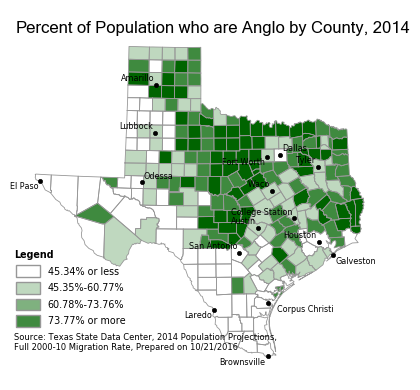

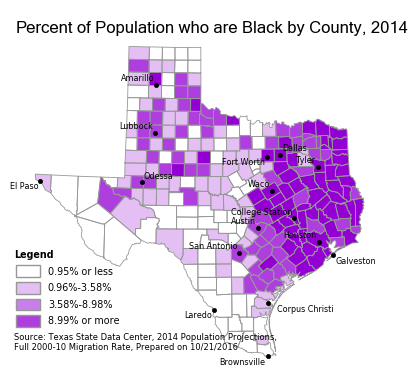

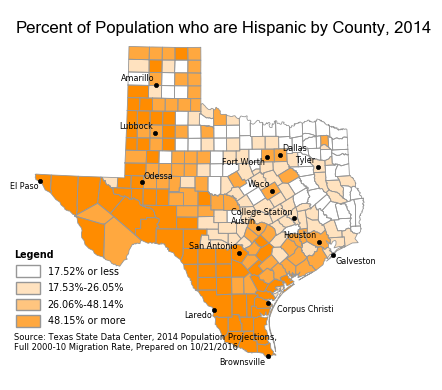

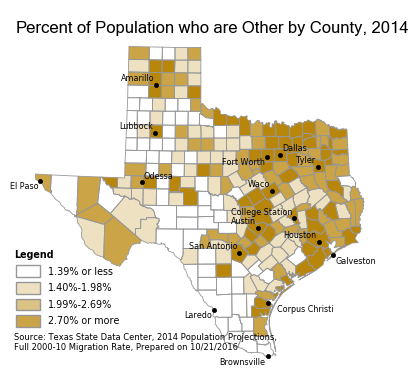

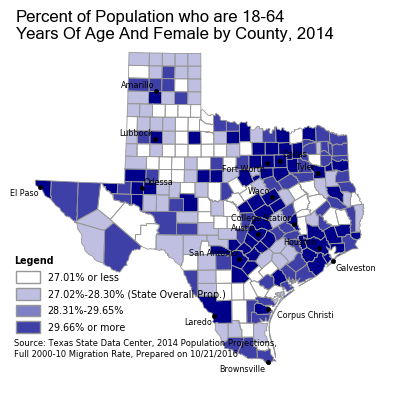

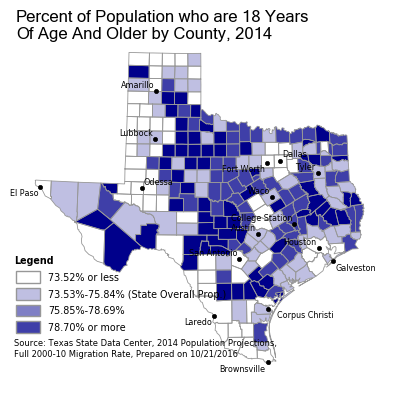

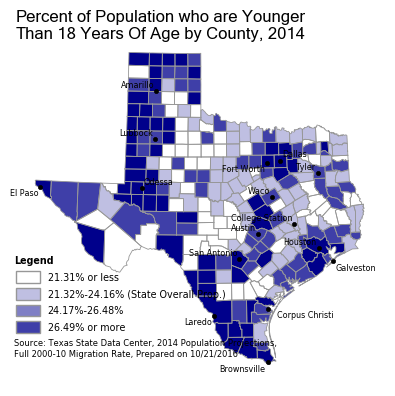

In [15]:
total_col = 'total'
fips_col = 'FIPS'
geofips_col = 'FIPS'
for c in cat_cols:
    cat_name = c.replace('total_', '').title().replace('_', ' ')
    title = 'Percent of Population who are %s by County, 2014' % cat_name
    colors = color_dict[c]

    # For some categories, we want to create custom bins around the state-level proportion
    if c in cat_cols[4:]:
        state_level = state_only_data[c]/state_only_data[total_col]
        bins = cshp.get_custom_bins(state_level)
        # Optional label for the legend
        level_labels = {1: '(State Overall Prop.)'}
    else:
        bins = None
        level_labels = None
    
    total_data = cshp.fix_FIPS(total_data, fips_col, '48')
    geodata = cshp.fix_FIPS(gpd.GeoDataFrame.from_file(COUNTY_SHP), geofips_col, '48')
    
    # Data object
    dataset = cshp.AreaPopDataset(total_data, geodata, fips_col, geofips_col, c,
                 total_col, footnote, cat_name, title,
                 None, 4, 2, level_labels, True)
    

    choropleth = cshp.Choropleth(dataset, colors, city_info, OUTPATH, False, True)

#     # And...make the map
    choropleth.plot()
